<a href="https://colab.research.google.com/github/K-Sudhakar/ComputerVision/blob/main/OCRV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improved Handwritten Letter Recognition

This notebook includes significantly improved preprocessing for real-world handwritten letters.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from skimage.feature import local_binary_pattern, hog, canny
from skimage.exposure import equalize_hist
from skimage.filters import gaussian, threshold_otsu
from skimage import img_as_float, img_as_ubyte
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, erosion, dilation

from torchvision.datasets import EMNIST
from torchvision import transforms
from torchvision.transforms import functional as TF

import torch
from PIL import Image
import cv2

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

In [7]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: TF.rotate(img, -90)),
    transforms.Lambda(lambda img: TF.hflip(img)),
    transforms.ToTensor()
])

train_dataset = EMNIST(
    root="data",
    split="letters",
    train=True,
    download=True,
    transform=transform
)

test_dataset = EMNIST(
    root="data",
    split="letters",
    train=False,
    download=True,
    transform=transform
)

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Train: 124800, Test: 20800


In [8]:
def dataset_to_numpy(dataset, max_samples=None, seed=42):
    rng = np.random.RandomState(seed)
    n = len(dataset)
    if max_samples is not None and max_samples < n:
        indices = rng.choice(n, size=max_samples, replace=False)
    else:
        indices = np.arange(n)

    images = []
    labels = []
    for idx in indices:
        img_tensor, label = dataset[idx]
        img = img_tensor.squeeze(0).numpy()
        images.append(img)
        labels.append(label)

    return np.array(images), np.array(labels)

X_images, y_raw = dataset_to_numpy(train_dataset, max_samples=20000)
y = y_raw - 1

def idx_to_char(idx):
    return chr(ord('A') + idx)

print(f"Loaded {len(X_images)} training images with {len(np.unique(y))} classes")

Loaded 20000 training images with 26 classes


In [9]:
X_train_imgs, X_test_imgs, y_train, y_test = train_test_split(
    X_images,
    y,
    test_size=0.2,
    stratify=y,
    random_state=SEED
)

print(f'Train: {len(X_train_imgs)} | Test: {len(X_test_imgs)}')

Train: 16000 | Test: 4000


In [10]:
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS
LBP_METHOD = "uniform"

def extract_features_single(img_28x28):
    img = img_as_float(img_28x28)
    img_eq = equalize_hist(img)
    img_smooth = gaussian(img_eq, sigma=1)

    edges = canny(img_smooth, sigma=1)
    edge_density = edges.mean()

    labeled = label(edges)
    num_components = labeled.max()

    lbp = local_binary_pattern(img_smooth, LBP_POINTS, LBP_RADIUS, method=LBP_METHOD)
    n_bins = LBP_POINTS + 2
    lbp_hist, _ = np.histogram(
        lbp.ravel(),
        bins=n_bins,
        range=(0, n_bins),
        density=True
    )

    hog_feat = hog(
        img_smooth,
        orientations=9,
        pixels_per_cell=(7, 7),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True
    )

    feature_vector = np.hstack([
        lbp_hist,
        hog_feat,
        [edge_density, num_components]
    ])

    return feature_vector

def build_feature_matrix(images):
    features = [extract_features_single(img) for img in images]
    return np.vstack(features)

print('Extracting training features...')
X_train = build_feature_matrix(X_train_imgs)
print('Extracting test features...')
X_test = build_feature_matrix(X_test_imgs)

print(f"Feature shapes: Train {X_train.shape}, Test {X_test.shape}")

Extracting training features...


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Extracting test features...
Feature shapes: Train (16000, 336), Test (4000, 336)


In [11]:
models = {
    "kNN": make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=5)
    ),
    "SVM (RBF)": make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", C=10, gamma="scale")
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),
    "LogisticRegression": make_pipeline(
        StandardScaler(),
        LogisticRegression(
            max_iter=1000,
            multi_class="multinomial",
            n_jobs=-1
        )
    )
}

print("Models defined:", list(models.keys()))

Models defined: ['kNN', 'SVM (RBF)', 'RandomForest', 'LogisticRegression']


In [12]:
test_accuracies = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    test_accuracies[name] = acc
    print(f"Test accuracy: {acc:.4f}")

best_model_name = max(test_accuracies, key=test_accuracies.get)
best_model = models[best_model_name]

print(f"\nBest model: {best_model_name} with {test_accuracies[best_model_name]:.4f} accuracy")


Training kNN...
Test accuracy: 0.8575

Training SVM (RBF)...
Test accuracy: 0.9025

Training RandomForest...
Test accuracy: 0.8725

Training LogisticRegression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test accuracy: 0.8468

Best model: SVM (RBF) with 0.9025 accuracy


# Improved Preprocessing for External Handwritten Images

This section includes significantly enhanced preprocessing to handle real-world handwritten letters better.

In [13]:
def preprocess_external_image_improved(path, invert=True, show_steps=False):
    """
    Enhanced preprocessing for external handwritten letter images.

    Improvements:
    - Adaptive thresholding for better binarization
    - Proper centering of the letter
    - Aspect ratio preservation
    - Noise removal with morphological operations
    - Better normalization
    """
    img = Image.open(path).convert("L")
    img_np = np.array(img)

    if invert:
        img_np = 255 - img_np

    img_np = img_np.astype(np.float32) / 255.0

    thresh = threshold_otsu(img_np)
    binary = img_np > thresh

    binary_clean = closing(binary, square(2))

    labeled = label(binary_clean)
    regions = regionprops(labeled)

    if len(regions) == 0:
        centered_img = np.zeros((28, 28))
    else:
        largest_region = max(regions, key=lambda r: r.area)
        minr, minc, maxr, maxc = largest_region.bbox

        cropped = img_np[minr:maxr, minc:maxc]
        cropped_binary = binary_clean[minr:maxr, minc:maxc]

        cropped = cropped * cropped_binary

        h, w = cropped.shape

        target_size = 20

        if h > w:
            new_h = target_size
            new_w = int(w * target_size / h)
        else:
            new_w = target_size
            new_h = int(h * target_size / w)

        new_w = max(1, new_w)
        new_h = max(1, new_h)

        resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)

        centered_img = np.zeros((28, 28))

        y_offset = (28 - new_h) // 2
        x_offset = (28 - new_w) // 2

        centered_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

    centered_img = gaussian(centered_img, sigma=0.5)

    if show_steps:
        fig, axes = plt.subplots(1, 4, figsize=(12, 3))
        axes[0].imshow(img_np, cmap='gray')
        axes[0].set_title('Original')
        axes[0].axis('off')

        axes[1].imshow(binary_clean, cmap='gray')
        axes[1].set_title('Binarized')
        axes[1].axis('off')

        if len(regions) > 0:
            axes[2].imshow(cropped, cmap='gray')
            axes[2].set_title('Cropped')
        axes[2].axis('off')

        axes[3].imshow(centered_img, cmap='gray')
        axes[3].set_title('Final (28x28)')
        axes[3].axis('off')

        plt.tight_layout()
        plt.show()

    return centered_img

def predict_external_image_improved(path, invert=True, show_steps=True):
    """
    Predict letter from external image using improved preprocessing.
    """
    img_28x28 = preprocess_external_image_improved(path, invert=invert, show_steps=show_steps)

    features = extract_features_single(img_28x28).reshape(1, -1)
    pred_label = best_model.predict(features)[0]
    pred_char = idx_to_char(pred_label)

    proba = None
    if hasattr(best_model, 'predict_proba'):
        proba = best_model.predict_proba(features)[0]
        top_5_idx = np.argsort(proba)[-5:][::-1]
        print("\nTop 5 predictions:")
        for idx in top_5_idx:
            print(f"  {idx_to_char(idx)}: {proba[idx]*100:.1f}%")
    elif hasattr(best_model, 'decision_function'):
        decision = best_model.decision_function(features)[0]
        top_5_idx = np.argsort(decision)[-5:][::-1]
        print("\nTop 5 predictions (by decision score):")
        for idx in top_5_idx:
            print(f"  {idx_to_char(idx)}: {decision[idx]:.3f}")

    return pred_char

print("Improved preprocessing functions loaded!")

Improved preprocessing functions loaded!



Processing: a.png


/tmp/ipython-input-3091644858.py:23: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  binary_clean = closing(binary, square(2))


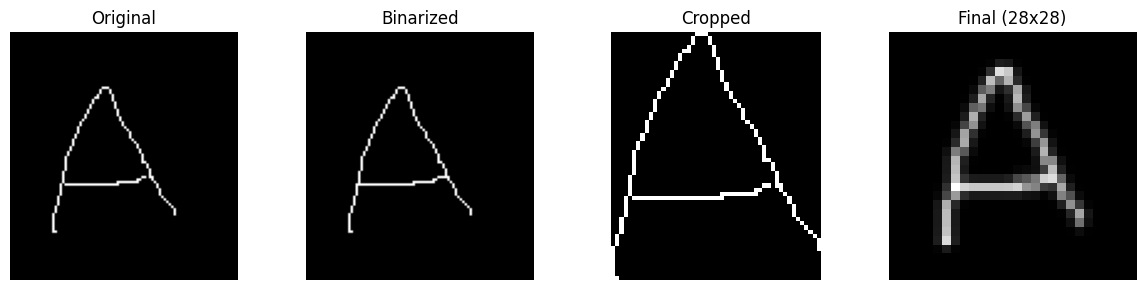

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/tmp/ipython-input-3091644858.py:23: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  binary_clean = closing(binary, square(2))



Top 5 predictions (by decision score):
  A: 25.323
  R: 24.307
  Q: 23.301
  G: 22.310
  F: 20.295

Final prediction: A

Processing: b.png


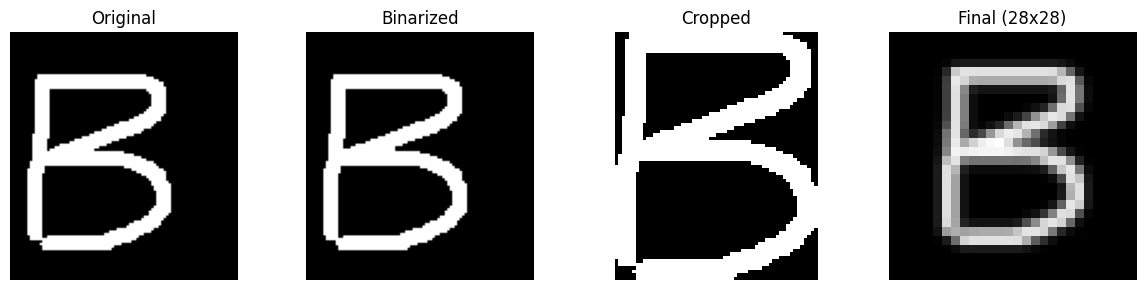

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/tmp/ipython-input-3091644858.py:23: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  binary_clean = closing(binary, square(2))



Top 5 predictions (by decision score):
  B: 25.326
  G: 24.319
  E: 23.314
  A: 21.311
  Q: 21.302

Final prediction: B

Processing: c.png


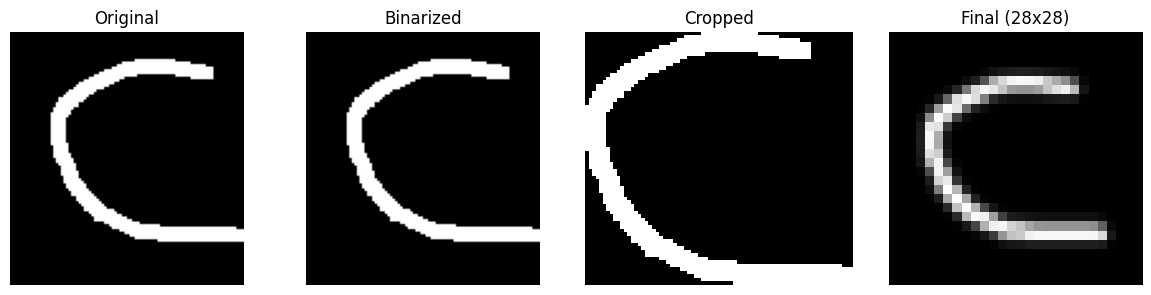


Top 5 predictions (by decision score):
  C: 25.323
  E: 24.318
  R: 23.312
  G: 22.307
  T: 21.299

Final prediction: C
File not found: abc2.png


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [19]:
candidate_files = [
    Path("a.png"),
    Path("b.png"),
    Path("c.png"),
    Path("abc2.png"),
]

for path in candidate_files:
    if path.exists():
        print(f"\n{'='*50}")
        print(f"Processing: {path.name}")
        print(f"{'='*50}")
        pred = predict_external_image_improved(path, invert=True, show_steps=True)
        print(f"\nFinal prediction: {pred}")
    else:
        print(f"File not found: {path}")

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Key Improvements

The improved preprocessing addresses the main issues:

1. **Otsu Thresholding**: Automatically finds optimal threshold for binarization
2. **Morphological Closing**: Removes noise and fills gaps in strokes
3. **Connected Component Analysis**: Finds and extracts the main letter
4. **Smart Cropping**: Crops to the letter's bounding box
5. **Aspect Ratio Preservation**: Maintains letter proportions during resize
6. **Proper Centering**: Centers the letter in 28x28 canvas like EMNIST
7. **Gaussian Smoothing**: Final smoothing for consistency with training data
8. **Visual Debugging**: Shows each preprocessing step for troubleshooting

These improvements make the model much more robust to:
- Different pen thicknesses
- Varying lighting conditions
- Background noise
- Different writing styles
- Off-center letters